# Analyzer configuration for running Table Transformer


In this notebook, we demonstrate how the [Table Transformer](https://github.com/microsoft/table-transformer) models can be utilized for table detection and table segmentation by adjusting the analyzer's default configuration. 

Additionally, we illustrate that modifying downstream parameters might be beneficial as well. We start from the default configuration and improve the quality of page parsing only by changing some processing parameters. The chosen configurations in this notebook may not be optimal, and we recommend continuing experimentation with the parameters, especially if fine-tuning models is not an option.

## General configuration

In [1]:
import os

os.environ["USE_DD_PILLOW"]="True"
os.environ["USE_DD_OPENCV"]="False"

import deepdoctection as dd
from matplotlib import pyplot as plt
from IPython.core.display import HTML

/home/janis/Documents/Repos/deepdoctection_pt/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[0712 14:20.17 @file_utils.py:36]  INF  PyTorch version 2.1.2+cu121 available.
[0712 14:20.17 @file_utils.py:74]  INF  Disabling Tensorflow because USE_TORCH is set


In [2]:

#path="/path/to/dir/sample/2312.13560.pdf" # Use the PDF in the sample folder
path = "/home/janis/Documents/Repos/notebooks/sample/2312.13560.pdf"
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",   # TATR table detection model
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",  # TATR table segmentation model
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",  # we disable Tesseract and use DocTr as OCR engine
    "OCR.USE_TESSERACT=False",
                        ])

[0712 14:20.18 @dd.py:464]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': None, 'PRIORITY': None, 'THRESHOLDS': None},
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': True,
         'USE_TESSERACT': False,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PDF_MINER': {'X_TOLERANCE': 3, 'Y_TOLERANCE': 3},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_inf_only.pt',
                 'WEIGHTS_TS': 'cell/d2_model_1849999_cell_inf_only.ts'},
        'ITEM': {'FILTER': ['table'],
 

The first configuration replaces the default layout and segmentation models with the registered table transformer models. The values need to be the equal to the model names in the `ModelCatalog`. You can find all registered model with `ModelCatalog.get_profile_list()`.

The table recognition model identifies tables again from cropped table regions. This is irrelevant for processing and actually leads to errors. For this reason, category `table` must be filtered out.

```yaml
PT:
   LAYOUT:
      WEIGHTS: microsoft/table-transformer-detection/pytorch_model.bin
   ITEM:
      WEIGHTS: microsoft/table-transformer-structure-recognition/pytorch_model.bin
      FILTER:
         - table
```

[0712 14:20.22 @doctectionpipe.py:84]  INF  Processing 2312.13560_0.pdf
[0712 14:20.24 @context.py:133]  INF  ImageLayoutService total: 0.6749 sec.
[0712 14:20.24 @context.py:133]  INF  SubImageLayoutService total: 0.0791 sec.
[0712 14:20.24 @context.py:133]  INF  PubtablesSegmentationService total: 0.0073 sec.
[0712 14:20.25 @context.py:133]  INF  ImageLayoutService total: 0.469 sec.
[0712 14:20.26 @context.py:133]  INF  TextExtractionService total: 0.6303 sec.
[0712 14:20.26 @context.py:133]  INF  MatchingService total: 0.004 sec.
[0712 14:20.26 @context.py:133]  INF  TextOrderService total: 0.0228 sec.


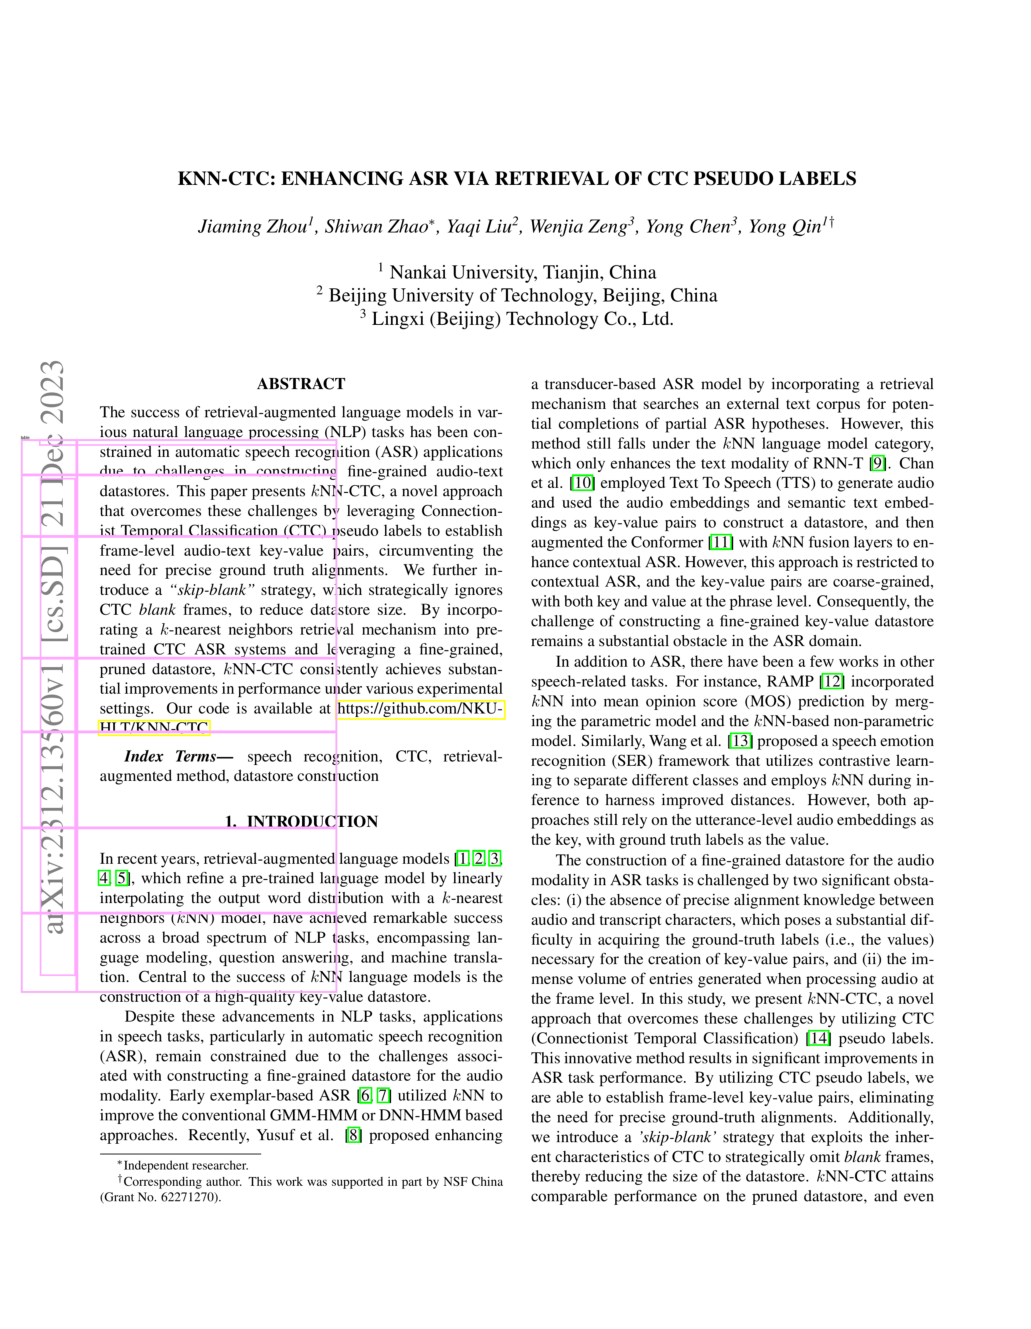

In [3]:
df = analyzer.analyze(path=path)
df.reset_state()
dp = next(iter(df))

np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [4]:
dp.tables[0].csv

[[' ', ' '],
 [' ',
  'datastores. This paper presents that overcomes these challenges by ist Temporal Classification (CTC) '],
 ['',
  'frame-level audio-text key-value need for precise ground truth troduce a "skip-blank - strategy, CTC blank frames, to reduce rating a k-nearest neighbors retrieval trained CTC ASR systems and '],
 ['',
  'pruned datastore, KNN-CTC tial improvements in performance settings. Our code is available at HLT/KNN-CTC '],
 ['', 'Index Terms- speech augmented method, datastore 1. '],
 ['',
  'In recent years, retrieval-augmented 45), which refine a pre-trained interpolating the output word '],
 ['',
  'neighbors (KNN) model, have across a broad spectrum of NLP guage modeling, question answering, tion. Central to the success of KNN ']]

In [5]:
dp.tables[0].score

0.4011545777320862

In [6]:
dp.text

''

Okay, table detection doesn't work at all. Besides that, we see that no text is recognized outside of the table. To suppress this poor table region prediction, we are increasing the filter confidence score to 0.4. We cannot change this directly in the `analyzer` configuration. 

The surrounding text is not displayed because the configuration only outputs the text within a layout segment. In this case, these are only tables. If we set `TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True`, line layout segments will be generated for all words, and all all line segments will be taken into account when generating narrative text.

In [7]:
#path="/path/to/dir/sample/2312.13560.pdf" # Use the PDF in the sample folder
path = "/home/janis/Documents/Repos/notebooks/sample/2312.13560.pdf"
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4  # default threshold is at 0.1

df = analyzer.analyze(path=path)
df.reset_state()
dp = next(iter(df))

np_image = dp.viz()

[0712 14:20.55 @dd.py:464]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': None, 'PRIORITY': None, 'THRESHOLDS': None},
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': True,
         'USE_TESSERACT': False,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PDF_MINER': {'X_TOLERANCE': 3, 'Y_TOLERANCE': 3},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_inf_only.pt',
                 'WEIGHTS_TS': 'cell/d2_model_1849999_cell_inf_only.ts'},
        'ITEM': {'FILTER': ['table'],
 

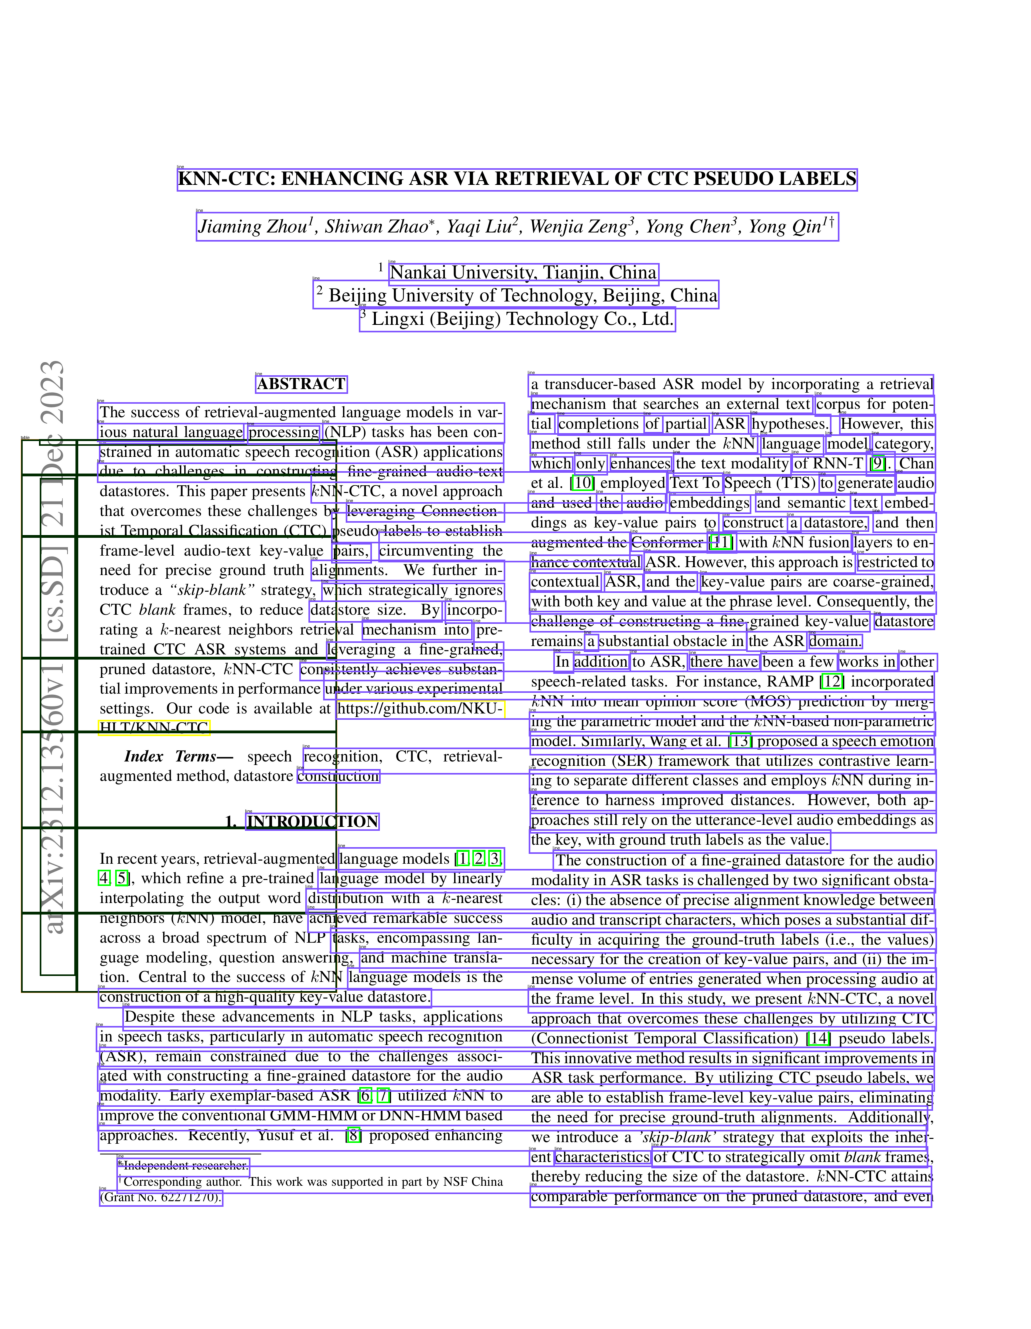

In [8]:
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [9]:
print(dp.text)

KNN-CTC: ENHANCING ASR VIA RETRIEVAL OF CTC PSEUDO LABELS
Jiaming Zhou', Shiwan Zhao*, Yaqi Liu, Wenjia Zeng, Yong Chen, Yong Qin't
Nankai University, Tianjin, China
2 Beijing University of Technology, Beijing, China
3 Lingxi (Beijing) Technology Co., Ltd.
a transducer-based ASR model by incorporating a retrieval
mechanism that searches an external text
corpus for poten-
tial
completions partial
of
ASR
hypotheses.
However, this
method still falls under the KNN
language
model
category,
which
only
enhances
the text modality
of RNN-T Chan
(9.
Text To
Speech (TTS) generate
audio
to
and used audio
the
embeddings
and semantic embed-
text
and then
construct datastore,
a
Conformer with KNN fusion
I
layers to en-
ASR. However, this approach is
hance contextual
restricted to
contextual
ASR,
and the
key-value pairs are coarse-grained,
with both key and value at the phrase level. Consequently, the
challenge of constructing a fine-grained key-value
datastore
the ASR
a
domain.
In
addition
to ASR,
th

The result is not much better. Although we are able to retrieve text outside tables, we observe that the text lines span across multiple columns. This leads to a disastrous outcome in terms of reading order. 

The construction of text lines is done heuristically. In particular, it is determined when adjacent words belong to the same text line and when text lines need to be separated, even if they are at the same horizontal level. 

By reducing the value of `TEXT_ORDERING.PARAGRAPH_BREAK`, we can achieve the splitting of text lines as soon as the word boxes exceed a minimum distance.

In [10]:
#path="/path/to/dir/sample/2312.13560.pdf" # Use the PDF in the sample folder
path = "/home/janis/Documents/Repos/notebooks/sample/2312.13560.pdf"
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
    "TEXT_ORDERING.PARAGRAPH_BREAK=0.01",  # default value is at 0.035 which might be too large
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

[0712 14:21.26 @dd.py:464]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': None, 'PRIORITY': None, 'THRESHOLDS': None},
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': True,
         'USE_TESSERACT': False,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PDF_MINER': {'X_TOLERANCE': 3, 'Y_TOLERANCE': 3},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_inf_only.pt',
                 'WEIGHTS_TS': 'cell/d2_model_1849999_cell_inf_only.ts'},
        'ITEM': {'FILTER': ['table'],
 

[0712 14:21.30 @doctectionpipe.py:84]  INF  Processing 2312.13560_0.pdf
[0712 14:21.32 @context.py:133]  INF  ImageLayoutService total: 0.0916 sec.
[0712 14:21.32 @context.py:133]  INF  SubImageLayoutService total: 0.0525 sec.
[0712 14:21.32 @context.py:133]  INF  PubtablesSegmentationService total: 0.0074 sec.
[0712 14:21.32 @context.py:133]  INF  ImageLayoutService total: 0.3105 sec.
[0712 14:21.33 @context.py:133]  INF  TextExtractionService total: 0.5153 sec.
[0712 14:21.33 @context.py:133]  INF  MatchingService total: 0.006 sec.
[0712 14:21.33 @context.py:133]  INF  TextOrderService total: 0.1446 sec.


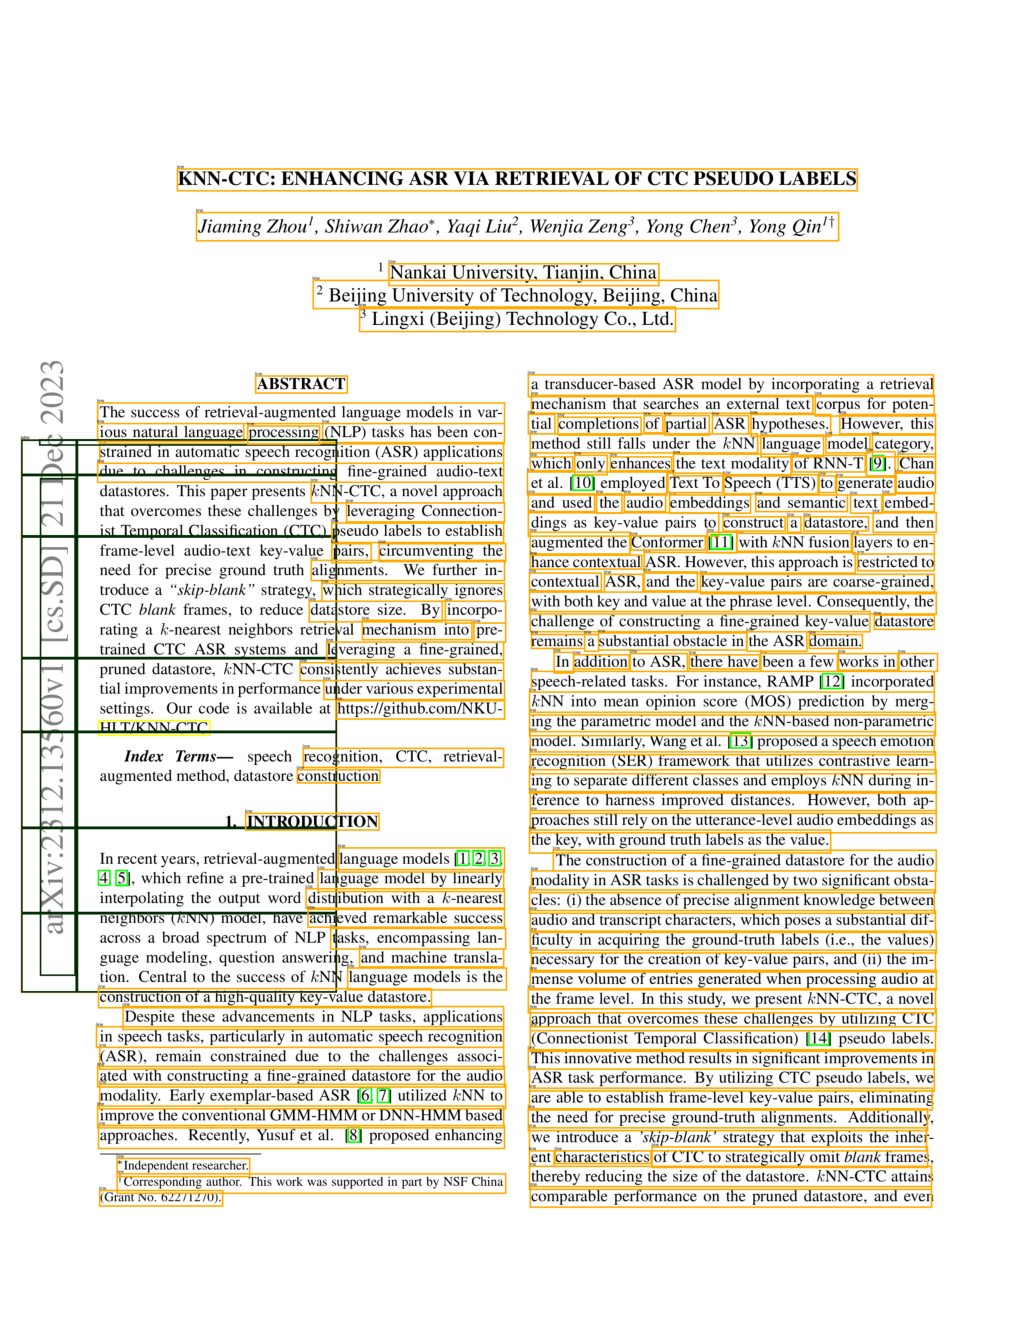

In [11]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [12]:
print(dp.text)

KNN-CTC: ENHANCING ASR VIA RETRIEVAL OF CTC PSEUDO LABELS
Jiaming Zhou', Shiwan Zhao*, Yaqi Liu, Wenjia Zeng, Yong Chen, Yong Qin't
Nankai University, Tianjin, China
2 Beijing University of Technology, Beijing, China
3 Lingxi (Beijing) Technology Co., Ltd.
ABSTRACT
The success of retrieval-augmented language models in var-
ious natural language
processing
(NLP) tasks has been con-
strained in automatic speech recognition (ASR) applications
due to challenges in constructing fine-grained audio-text
KNN-CTC, a novel approach
leveraging Connection-
pseudo labels to establish
pairs,
circumventing the
alignments. We further in-
which strategically ignores
datastore size. By
incorpo-
mechanism into
pre-
leveraging a fine-grained,
consistently achieves substan-
under various experimental
htps/gibcomAKU:
recognition, CTC, retrieval-
construction
INTRODUCTION
language models 123
language model by linearly
distribution with a k-nearest
achieved remarkable success
tasks, encompassing lan-
and mach

Okay, this page looks good now. Let's continue scrolling through the document.

[0712 14:21.41 @doctectionpipe.py:84]  INF  Processing 2312.13560_1.pdf
[0712 14:21.43 @context.py:133]  INF  ImageLayoutService total: 0.1019 sec.
[0712 14:21.43 @context.py:133]  INF  SubImageLayoutService total: 0.0663 sec.
[0712 14:21.43 @context.py:133]  INF  PubtablesSegmentationService total: 0.0021 sec.
[0712 14:21.43 @context.py:133]  INF  ImageLayoutService total: 0.2856 sec.
[0712 14:21.44 @context.py:133]  INF  TextExtractionService total: 0.4981 sec.
[0712 14:21.44 @context.py:133]  INF  MatchingService total: 0.0036 sec.
[0712 14:21.44 @context.py:133]  INF  TextOrderService total: 0.1224 sec.


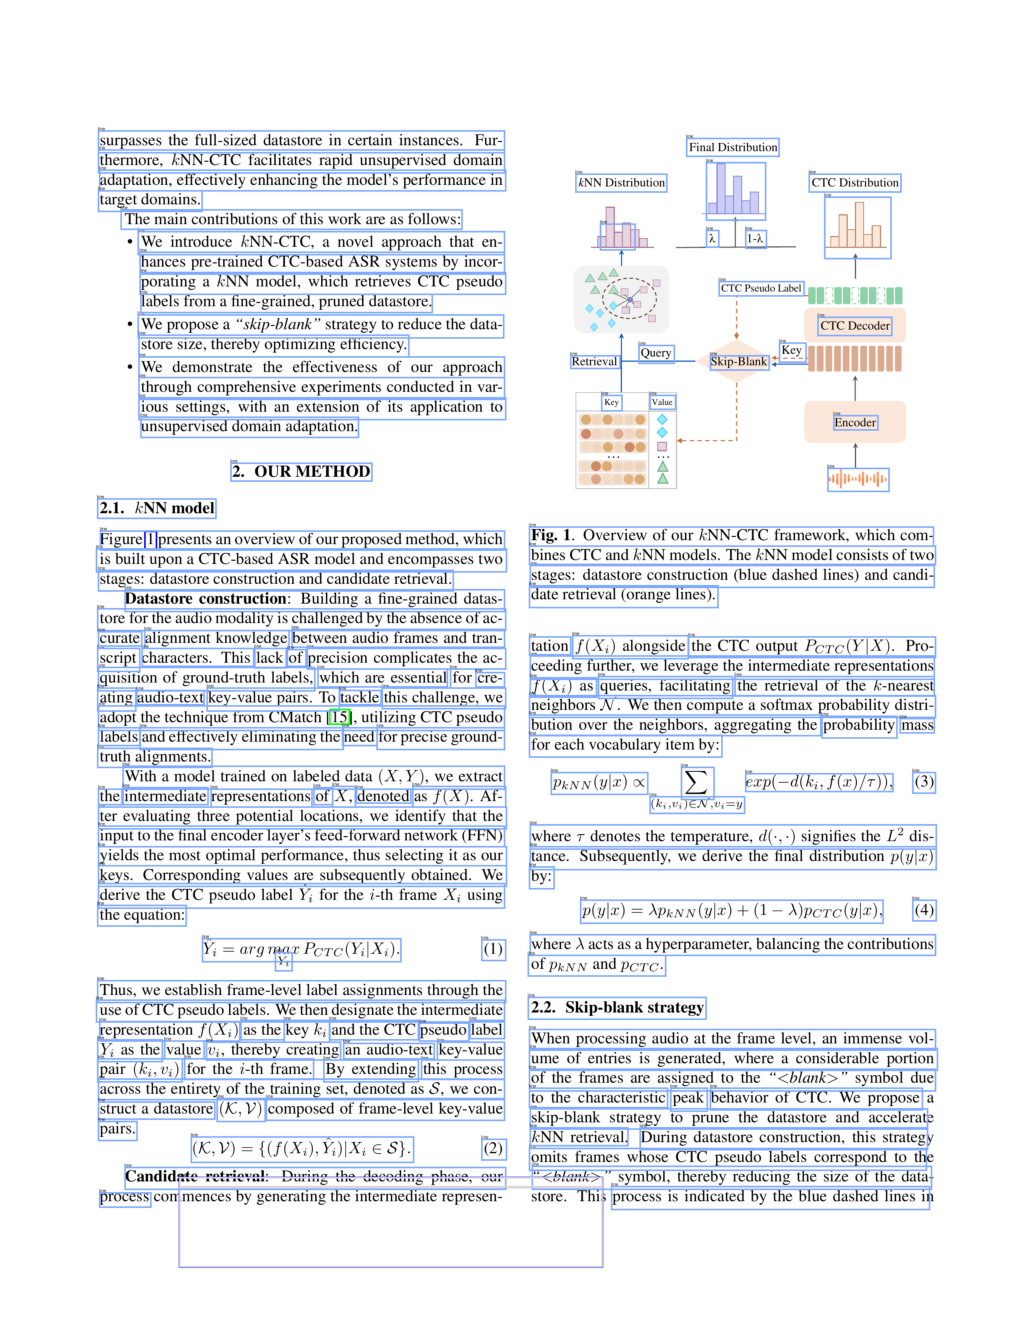

In [13]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

Once again, we observe a false positive, this time with an even higher confidence threshold. We are not going to increase the threshold, though.

In [14]:
dp.tables[0].score

0.7092703580856323

In [15]:
print(dp.text)

surpasses the full-sized datastore in certain instances. Fur-
thermore, KNN-CTC facilitates rapid unsupervised domain
adaptation, effectively enhancing the model's performance in
target domains.
The main contributions of this work are as follows:
We introduce KNN-CTC, a novel approach that en-
hances pre-trained CTC-based ASR systems by incor-
porating a KNN model, which retrieves CTC pseudo
labels from a fine-grained, pruned datastore.
We propose a "skip-blank" strategy to reduce the data-
store size, thereby optimizing efficiency.
We demonstrate the effectiveness of our approach
through comprehensive experiments conducted in var-
ious settings, with an extension of its application to
unsupervised domain adaptation.
2. OUR METHOD
2.1. KNN model
Figurepresents an overview of our proposed method, which
is built upon a CTC-based ASR model and encompasses two
stages: datastore construction and candidate retrieval.
Datastore construction: Building a fine-grained datas-
tore for the audio m

[0712 14:21.52 @doctectionpipe.py:84]  INF  Processing 2312.13560_2.pdf
[0712 14:21.54 @context.py:133]  INF  ImageLayoutService total: 0.4062 sec.
[0712 14:21.54 @context.py:133]  INF  SubImageLayoutService total: 0.0734 sec.
[0712 14:21.54 @context.py:133]  INF  PubtablesSegmentationService total: 0.0071 sec.
[0712 14:21.54 @context.py:133]  INF  ImageLayoutService total: 0.3449 sec.
[0712 14:21.55 @context.py:133]  INF  TextExtractionService total: 0.5961 sec.
[0712 14:21.55 @context.py:133]  INF  MatchingService total: 0.0048 sec.
[0712 14:21.55 @context.py:133]  INF  TextOrderService total: 0.1335 sec.


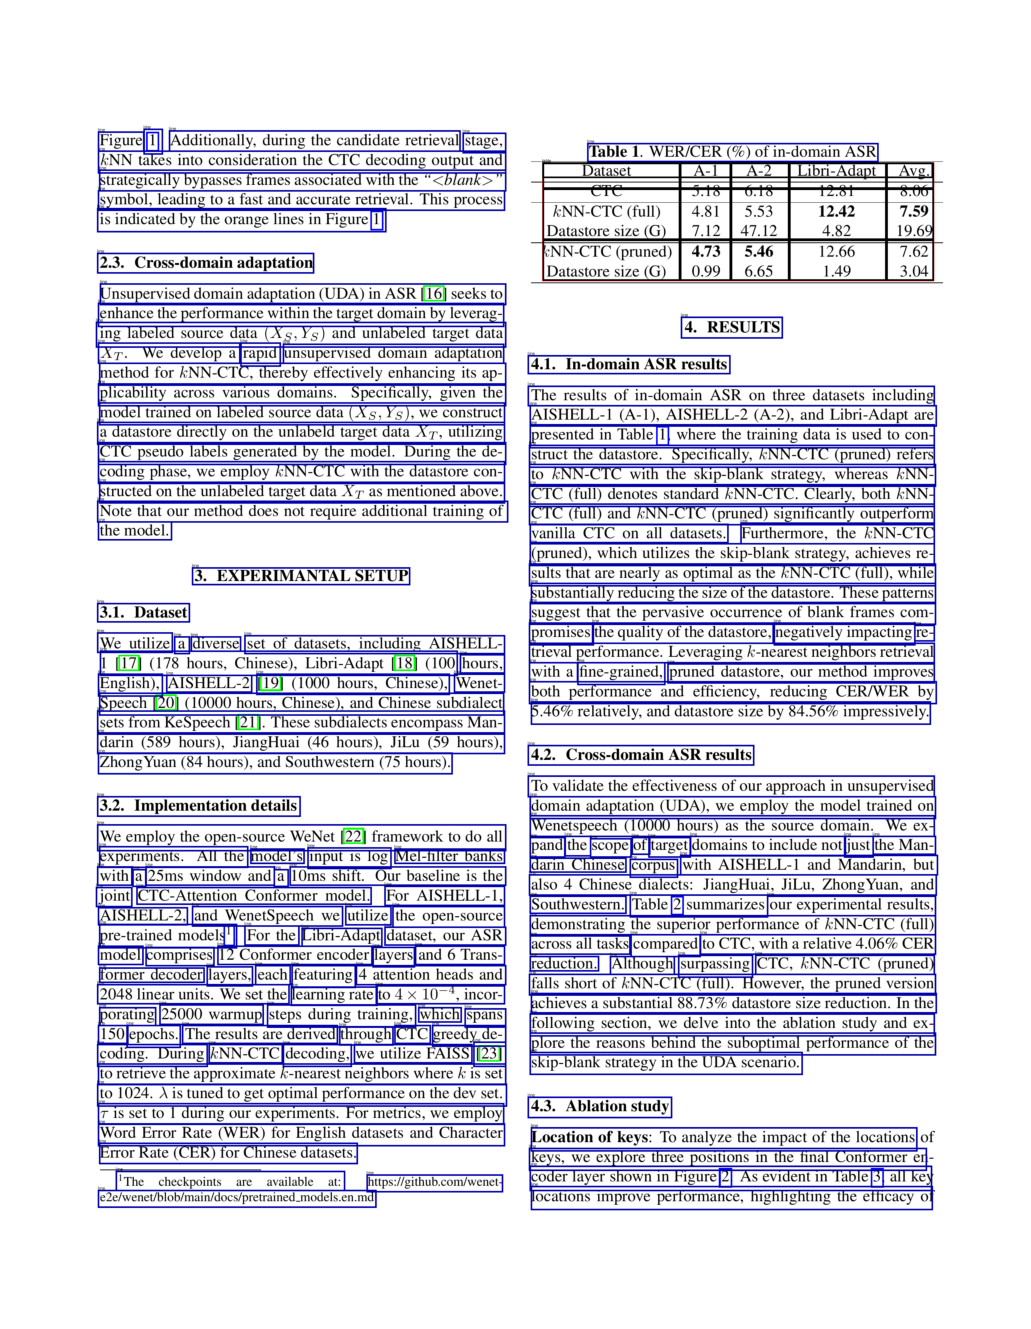

In [16]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

[0712 14:22.04 @doctectionpipe.py:84]  INF  Processing 2312.13560_3.pdf
[0712 14:22.05 @context.py:133]  INF  ImageLayoutService total: 0.0916 sec.
[0712 14:22.06 @context.py:133]  INF  SubImageLayoutService total: 0.2327 sec.
[0712 14:22.06 @context.py:133]  INF  PubtablesSegmentationService total: 0.0253 sec.
[0712 14:22.06 @context.py:133]  INF  ImageLayoutService total: 0.3089 sec.
[0712 14:22.06 @context.py:133]  INF  TextExtractionService total: 0.4814 sec.
[0712 14:22.06 @context.py:133]  INF  MatchingService total: 0.0043 sec.
[0712 14:22.06 @context.py:133]  INF  TextOrderService total: 0.114 sec.


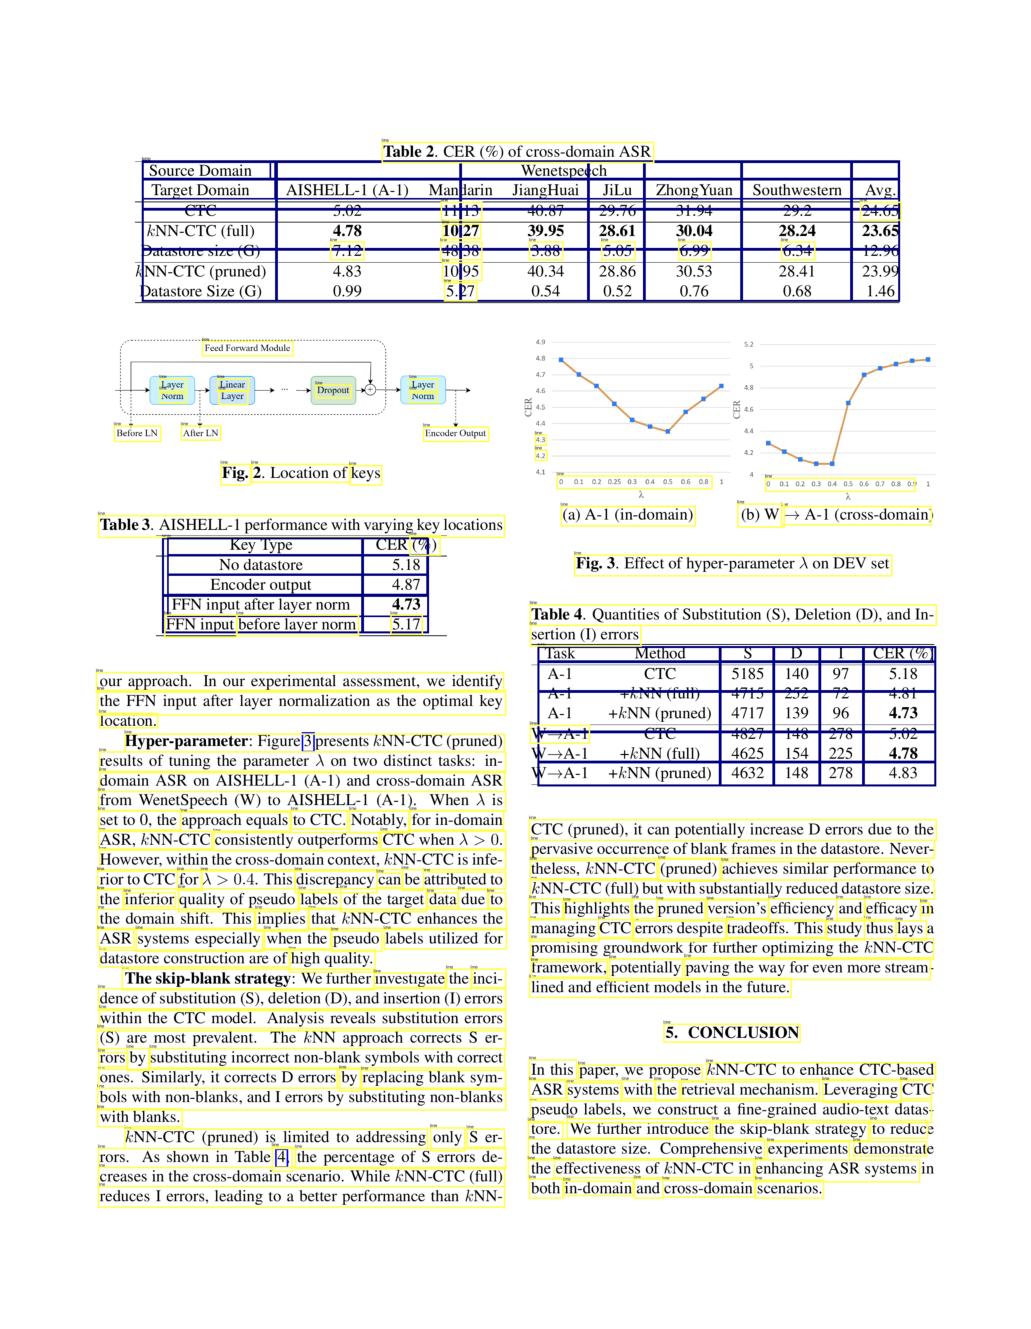

In [17]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

The results now look quite decent, and the segmentation is also yielding usable outcomes. However, as noted in many instances, it should be acknowledged that the models may produce much weaker results on other types of documents.

## Table segmentation

We will now take a look at another example, focusing on optimizations in table segmentation.

In [18]:
#path="/path/to/dir/sample/finance" # Use the PDF in the sample folder
path = "/home/janis/Documents/Repos/notebooks/sample/finance"
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
    "TEXT_ORDERING.PARAGRAPH_BREAK=0.01",
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4  # default threshold is at 0.1

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

[0712 14:22.49 @dd.py:464]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': None, 'PRIORITY': None, 'THRESHOLDS': None},
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': True,
         'USE_TESSERACT': False,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PDF_MINER': {'X_TOLERANCE': 3, 'Y_TOLERANCE': 3},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_inf_only.pt',
                 'WEIGHTS_TS': 'cell/d2_model_1849999_cell_inf_only.ts'},
        'ITEM': {'FILTER': ['table'],
 

[0712 14:22.53 @doctectionpipe.py:84]  INF  Processing 1bcac3899c9cb1c0b0f650b1431d3d52_7.png
[0712 14:22.54 @context.py:133]  INF  ImageLayoutService total: 0.1243 sec.
[0712 14:22.54 @context.py:133]  INF  SubImageLayoutService total: 0.2203 sec.
[0712 14:22.54 @context.py:133]  INF  PubtablesSegmentationService total: 0.0782 sec.
[0712 14:22.54 @context.py:133]  INF  ImageLayoutService total: 0.1918 sec.
[0712 14:22.55 @context.py:133]  INF  TextExtractionService total: 0.24 sec.
[0712 14:22.55 @context.py:133]  INF  MatchingService total: 0.0034 sec.
[0712 14:22.55 @context.py:133]  INF  TextOrderService total: 0.0475 sec.


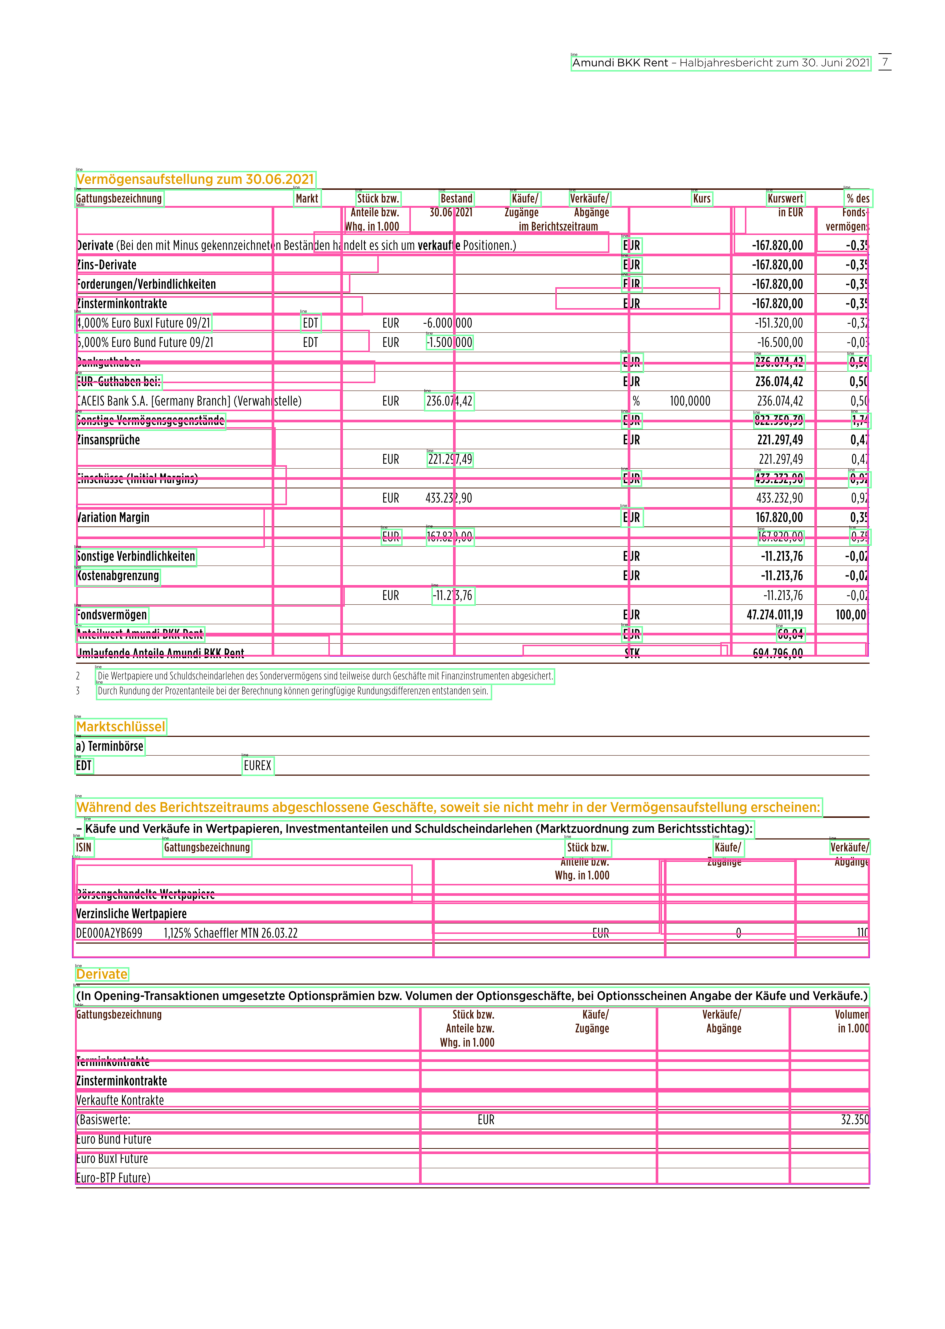

In [19]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [20]:
HTML(dp.tables[0].html)

[0712 14:23.02 @view.py:326]  WRN  html construction not possible


In [21]:
HTML(dp.tables[1].html)

[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible
[0712 14:23.02 @view.py:326]  WRN  html construction not possible


The table segmentation incorporates various cell types identified by the segmentation model and processes them. Unfortunately, the detection of, for example, spanning cells does not work particularly well. This can be observed from the last sample where the model identifies at first column contains a spanning cell. We want to deactivate this feature. To do this, we need to filter out all cell types.

In [22]:
#path="/path/to/dir/sample/finance" # Use the PDF in the sample folder
path = "/home/janis/Documents/Repos/notebooks/sample/finance"
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table','column_header','projected_row_header','spanning']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
    "TEXT_ORDERING.PARAGRAPH_BREAK=0.01",
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

[0712 14:23.28 @dd.py:464]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': None, 'PRIORITY': None, 'THRESHOLDS': None},
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': True,
         'USE_TESSERACT': False,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PDF_MINER': {'X_TOLERANCE': 3, 'Y_TOLERANCE': 3},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_inf_only.pt',
                 'WEIGHTS_TS': 'cell/d2_model_1849999_cell_inf_only.ts'},
        'ITEM': {'FILTER': ['table', 'c

[0712 14:23.32 @doctectionpipe.py:84]  INF  Processing 1bcac3899c9cb1c0b0f650b1431d3d52_7.png
[0712 14:23.32 @context.py:133]  INF  ImageLayoutService total: 0.0824 sec.
[0712 14:23.32 @context.py:133]  INF  SubImageLayoutService total: 0.1273 sec.
[0712 14:23.32 @context.py:133]  INF  PubtablesSegmentationService total: 0.0386 sec.
[0712 14:23.32 @context.py:133]  INF  ImageLayoutService total: 0.1981 sec.
[0712 14:23.33 @context.py:133]  INF  TextExtractionService total: 0.2148 sec.
[0712 14:23.33 @context.py:133]  INF  MatchingService total: 0.0038 sec.
[0712 14:23.33 @context.py:133]  INF  TextOrderService total: 0.0493 sec.


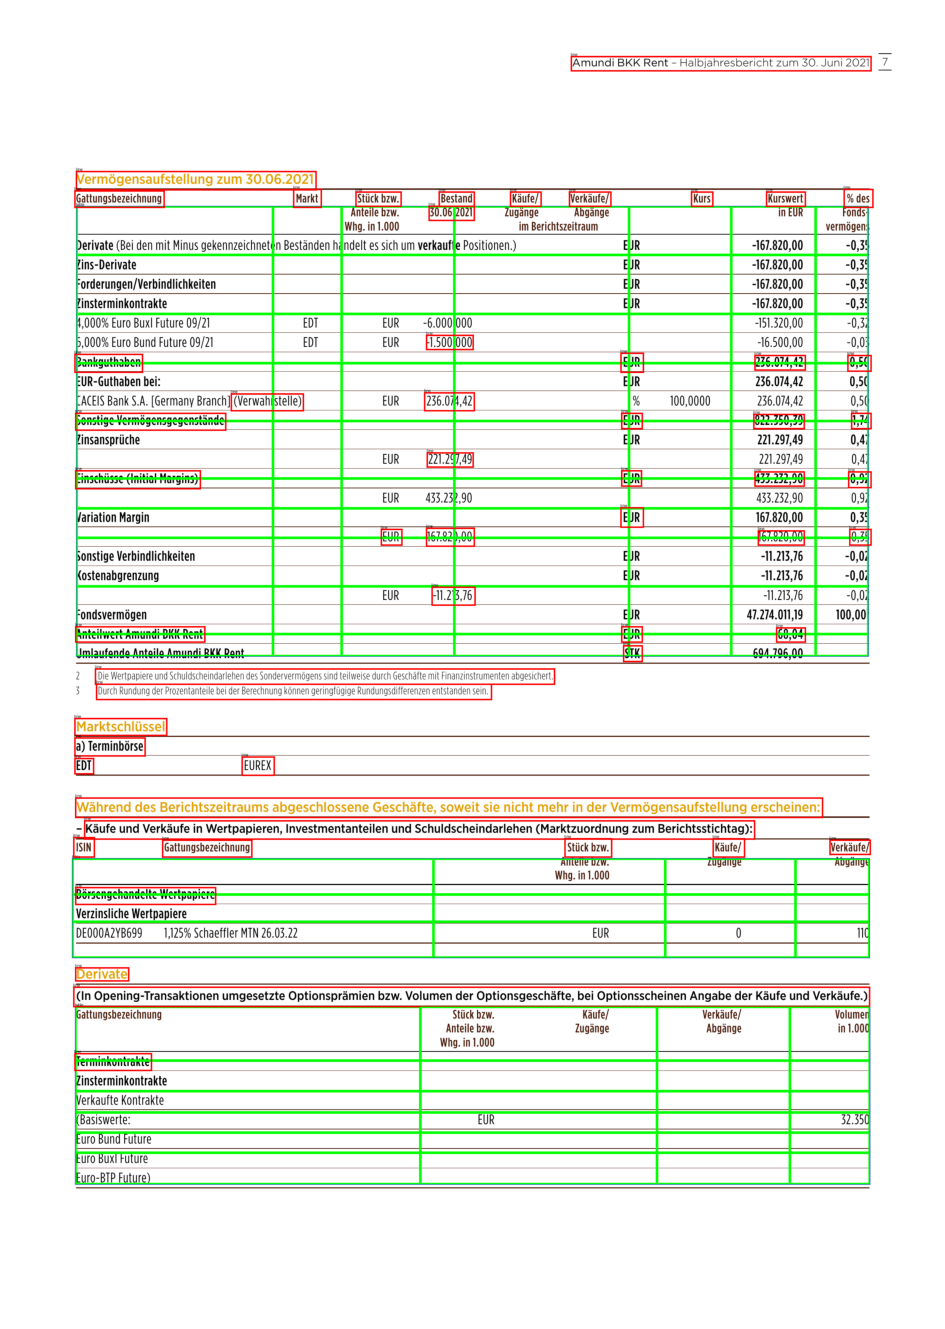

In [23]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [24]:
HTML(dp.tables[0].html)

In [25]:
HTML(dp.tables[1].html)

In [26]:
HTML(dp.tables[2].html)

As already mentiond, all text that is not part of table cells will be pushed into the narrative text.

In [27]:
print(dp.text)

Amundi BKK Rent - Halbjahresbericht zum 30. Juni 2021
Vermogensaufstelung zum 30.06.2021
Gattungbezeichnung
Markt
Stuck bzw.
Bestand
30.06.2021
Kâufe/
Verkâufe/
Kurs
Kurswert
%des
-1.500.000
Bankguthaben
EUR
236.074,42
0,50
(Verwahrstelle)
236.074,42
Sonstige Vermogensgegenstande
EUR
822.350,39
1,74
221.297,49
Einschusse (Initial Margins)
EUR
EUR
433.232,90
0,92
EUR
167.820,00
167.820,00
0,35
-1.213,76
Anteilwert Amundi BKK Rent
EUR
STK
68,04
Die Wertpapiere und Schuldscheindarlehen des Sondervermogens sind teilweise durch Geschâfte mit Finanzinstrumenten abgesichert.
Durch Rundung der Prozentanteile bei der Berechnung kônnen geringfugige Rundungsdifferenzen entstanden sein.
Marktschlussel
a) Terminborse
EDT
EUREX
Wahrend des Berichtszeitraums abgeschlossene Geschâfte, soweit sie nicht mehr in der Vermogensaufstelung erscheinen:
Kâufe und Verkâufe in Wertpapieren, Investmentanteilen und Schuidscheindariehen (Marktzuordnung zum Berichtsstichtag):
ISIN
Gattungsbezeichnung
Stick bzw.
Kâuf

There are additional configuration parameters that can improve segmentation. These include, for example, `SEGMENTATION.THRESHOLD_ROWS`, `SEGMENTATION.THRESHOLD_COLS`, `SEGMENTATION.REMOVE_IOU_THRESHOLD_ROWS`, and `SEGMENTATION.REMOVE_IOU_THRESHOLD_COLS`. To observe the effects, we recommend experimenting with these parameters.